<a href="https://colab.research.google.com/github/drago467/Deep-Facial-Recognition-App/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow depencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

!tar -xf lfw.tgz

--2024-09-15 14:05:15--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M   913KB/s    in 3m 8s   

2024-09-15 14:08:24 (936 KB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    # Tạo đường dẫn đầy đủ đến thư mục con
    directory_path = os.path.join('lfw', directory)

    # Kiểm tra nếu đường dẫn là một thư mục
    if os.path.isdir(directory_path):
        for file in os.listdir(directory_path):
            EX_PATH = os.path.join(directory_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [9]:
 # Import uuid library to generate unique image names
 import uuid

 # Establish a connection to the webcam
 cap = cv2.VideoCapture(4)
 while cap.isOpened():
  ret, frame = cap.read()

  # Cut down  frame to 250x250px
  frame = frame[120:120+250,200:200+250, :]

  # Collect anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Collect possitives
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Show image back to screen
  cv2.imshow('Image Collection', frame)

  # Breaking gracefully
  if cv2.waikey(1) & OXFF == ord('q'):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
import os

# Tạo thư mục đích nếu chưa tồn tại
destination_dir = '/content/data/anchor'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Sao chép tất cả các tệp ảnh (.jpg, .jpeg, .png) từ Google Drive
!cp /content/drive/MyDrive/anchor/*.{jpg,jpeg,png} /content/data/anchor/


cp: cannot stat '/content/drive/MyDrive/anchor/*.jpeg': No such file or directory
cp: cannot stat '/content/drive/MyDrive/anchor/*.png': No such file or directory


In [17]:
import os

# Tạo thư mục đích nếu chưa tồn tại
destination_dir = '/content/data/positive'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Sao chép tất cả các tệp ảnh (.jpg, .jpeg, .png) từ Google Drive
!cp /content/drive/MyDrive/positive/*.{jpg,jpeg,png} /content/data/positive/


cp: cannot stat '/content/drive/MyDrive/positive/*.jpeg': No such file or directory
cp: cannot stat '/content/drive/MyDrive/positive/*.png': No such file or directory


In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [21]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/c5fa362e-72af-11ef-8bc9-701ab85ee0c9.jpg'

#**3.2 Preprocessing - Scale and Resize**

In [20]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100,100))
  img = img / 255.0
  return img

## **3.3 Create Labelled Dataset**

In [77]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [78]:
samples = data.as_numpy_iterator()

In [79]:
samples.next()

(b'data/anchor/07a8df4f-72b0-11ef-b55d-701ab85ee0c9.jpg',
 b'data/positive/eb799da9-72b0-11ef-a560-701ab85ee0c9.jpg',
 1.0)

In [80]:
samples.next()[0]

b'data/anchor/cb5d0c45-72af-11ef-b8c8-701ab85ee0c9.jpg'

## **3.4 Build Train and Test Partition**

In [81]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [82]:
res = preprocess_twin(*samples.next())

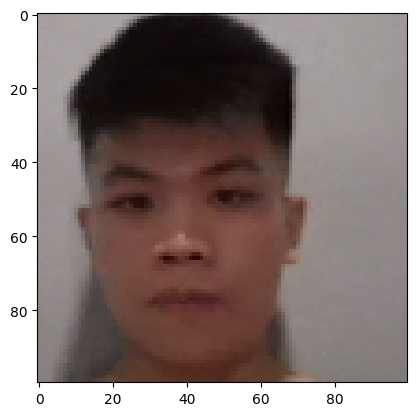

In [83]:
plt.imshow(res[1])

In [84]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [85]:
samples = data.as_numpy_iterator()

In [86]:
samples.next()

(array([[[0.6492647 , 0.5708333 , 0.46495098],
         [0.65294117, 0.56764704, 0.46078432],
         [0.6514706 , 0.55735296, 0.44754902],
         ...,
         [0.99607843, 0.99215686, 0.9843137 ],
         [0.99607843, 0.99215686, 0.9843137 ],
         [0.99607843, 0.9882353 , 0.99215686]],
 
        [[0.6637255 , 0.58431375, 0.47843137],
         [0.65416664, 0.5688726 , 0.46200982],
         [0.6632353 , 0.56764704, 0.45857844],
         ...,
         [0.99607843, 0.99215686, 0.9823529 ],
         [0.99607843, 0.99215686, 0.98382354],
         [0.99607843, 0.99215686, 0.9843137 ]],
 
        [[0.6752451 , 0.59289217, 0.4870098 ],
         [0.6634804 , 0.5781863 , 0.47132352],
         [0.6718137 , 0.5740196 , 0.46053922],
         ...,
         [0.99607843, 0.99215686, 0.9764706 ],
         [0.99607843, 0.99215686, 0.97794116],
         [0.99607843, 0.99215686, 0.9843137 ]],
 
        ...,
 
        [[0.58210784, 0.5154412 , 0.39779413],
         [0.5865196 , 0.51642156, 0.39877

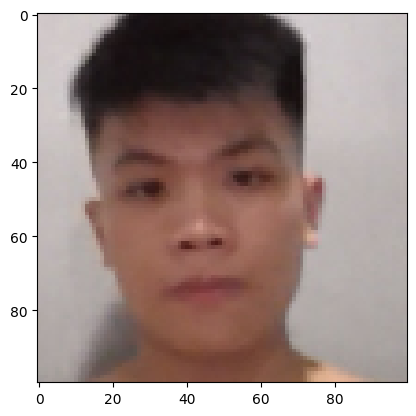

In [88]:
plt.imshow(samples.next()[1])

# **4. Model Engineering**

## **4.1 Build Embedding Layer**

In [40]:
inp = Input( shape=(100, 100, 3), name='input_image')

# First block
c1 = Conv2D(64, (10, 10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

# Second block
c2 = Conv2D(128, (7, 7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

# Third block
c3 = Conv2D(128, (4, 4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

# Final ebedding block
c4 = Conv2D(256, (4, 4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [41]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
def make_embedding():
  inp = Input( shape=(100, 100, 3), name='input_image')

  # First block
  c1 = Conv2D(64, (10, 10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

  # Second block
  c2 = Conv2D(128, (7, 7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

  # Third block
  c3 = Conv2D(128, (4, 4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

  # Final ebedding block
  c4 = Conv2D(256, (4, 4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
embedding = make_embedding()

In [54]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## **4.2 Build Distance Layer**

In [50]:
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()


  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [51]:
l1 = L1Dist()

In [52]:
l1

<L1Dist name=l1_dist_1, built=False>

## **4.3 Make Siamese Model**

In [ ]:
def make_siamese_model():

  # Anchor image input in the network
  input_image = Input(name='input_img', shape=(100, 100, 3))

  # Validation image in the network
  validation_image = Input(name='validation_img', shape=(100, 100, 3))

  # Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification Layer
  classifier = Dense(1, activation='sigmoid')(distances)
  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# **5. Trainning**

## **5.1 Setup Loss and Optimizer**

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [56]:
opt = tf.keras.optimizers.Adam(1e-4)

## **5.2 Establish Checkpoints**

In [ ]:
checkpoint_dir = './training_checkpoints'
os.makedirs('content/training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## **5.3 Build Train Step Function**

In [ ]:
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    # Get anchor and positive/negative image
    X = batch[:2]
    # Get label
    y = batch[2]

    # Forward pass
    yhat = siamese_model(X, training=True)
    # Calculate loss
    loss = binary_cross_loss(y, yhat)

  print(loss)

  # Calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  # Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

## **5.4 Build Training Loop**

In [60]:
def train(data, EPOCHS):

  # Loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    # Loop through each batch
    for idx, batch in enumerate(data):
      # Run train step here
      train_step(batch)
      progbar.update(idx+1)
    progbar = tf.keras.utils.Progbar(len(data))

    # Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

## **5.5 Train the model**

In [58]:
EPOCHS = 50

In [61]:
train(train_data, EPOCHS)

NameError: name 'train_data' is not defined